# Gpx to Csv research data converter
The objective of this project is to convert GPS data in GPX format to CSV format for easier analysis. The idea is to extract relevant information such as latitude, longitude, elevation, and timestamp from GPX files and save it in a structured CSV format on 1km splits, so its more human-readable.

## Sample GPX File Record

This is a sample track point from a GPX file:

```xml
<trkpt lat="14.5366526953876018524169921875" lon="-90.883334577083587646484375">
  <ele>2430.800048828125</ele>
  <time>2025-10-19T09:17:48.000Z</time>
  <extensions>
    <ns3:TrackPointExtension>
      <ns3:atemp>22.0</ns3:atemp>
      <ns3:hr>85</ns3:hr>
      <ns3:cad>0</ns3:cad>
    </ns3:TrackPointExtension>
  </extensions>
</trkpt>
```

**Key fields:**
- `lat`/`lon`: Geographic coordinates
- `ele`: Elevation in meters
- `time`: Timestamp
- `atemp`: Ambient temperature (°C)
- `hr`: Heart rate (bpm)
- `cad`: Cadence (steps/min)

## Desired CSV Output Format

The output CSV should contain 1km split data with the following columns:

| Lap | Time | Distance | Avg Pace | Avg HR | Total Ascent | Total Descent |
|-----|------|----------|----------|--------|--------------|---------------|

## GPX File Analysis: activity_20738496042.gpx

**Activity Overview:**
- **Activity Name:** Acatenango Trail Running
- **Activity Type:** Trail Running
- **Date:** October 19, 2025
- **Start Time:** 09:17:48 UTC
- **End Time:** 16:10:36 UTC
- **Duration:** ~6 hours 53 minutes

**File Structure:**
- **Total Lines:** 104,464 lines
- **Track Points:** ~10,446 data points (one point every ~2.4 seconds on average)
- **Recording Frequency:** Variable (1-5 second intervals)

**Data Fields Available:**
- Geographic coordinates (latitude, longitude)
- Elevation (meters)
- Timestamp
- Ambient temperature (°C)
- Heart rate (bpm)
- Cadence (steps/min)

**Elevation Profile:**
- Starting elevation: ~2,430m
- Ending elevation: ~2,420m
- Notable: This is a high-altitude trail run (Acatenango volcano area in Guatemala)

**Heart Rate Range Observed:**
- Start: 85-88 bpm
- End: 106 bpm
- Temperature: 22-23°C throughout the activity

In [45]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Earth using the Haversine formula.
    Returns distance in meters.
    """
    R = 6371000  # Earth's radius in meters
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

def calculate_elevation_gain_loss(elevations, threshold=2.0):
    """
    Calculate elevation gain and loss using Garmin-style algorithm.
    Accumulates elevation changes and only counts when threshold is exceeded.
    
    Parameters:
    - elevations: List of elevation values in meters
    - threshold: Minimum accumulated change to count (default: 2.0m)
    
    Returns:
    - (total_ascent, total_descent) in meters
    """
    if len(elevations) < 2:
        return 0, 0
    
    total_ascent = 0
    total_descent = 0
    accumulated_gain = 0
    accumulated_loss = 0
    
    for i in range(len(elevations) - 1):
        diff = elevations[i+1] - elevations[i]
        
        if diff > 0:
            # Going up
            accumulated_gain += diff
            accumulated_loss = 0  # Reset descent accumulator
            
            # If we've accumulated enough gain, count it
            if accumulated_gain >= threshold:
                total_ascent += accumulated_gain
                accumulated_gain = 0
        else:
            # Going down
            accumulated_loss += abs(diff)
            accumulated_gain = 0  # Reset ascent accumulator
            
            # If we've accumulated enough loss, count it
            if accumulated_loss >= threshold:
                total_descent += accumulated_loss
                accumulated_loss = 0
    
    # Add any remaining accumulated values
    if accumulated_gain >= threshold:
        total_ascent += accumulated_gain
    if accumulated_loss >= threshold:
        total_descent += accumulated_loss
    
    return total_ascent, total_descent

def parse_gpx_to_splits(gpx_file_path, split_distance=1000, elevation_threshold=2.0):
    """
    Parse GPX file and generate 1km split data.
    
    Parameters:
    - gpx_file_path: Path to the GPX file
    - split_distance: Distance for each split in meters (default: 1000m = 1km)
    - elevation_threshold: Minimum accumulated elevation change to count (default: 2.0m)
    
    Returns:
    - DataFrame with split data
    """
    # Parse XML
    tree = ET.parse(gpx_file_path)
    root = tree.getroot()
    
    # Define namespaces
    ns = {
        'gpx': 'http://www.topografix.com/GPX/1/1',
        'ns3': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'
    }
    
    # Extract all track points
    track_points = []
    for trkpt in root.findall('.//gpx:trkpt', ns):
        lat = float(trkpt.get('lat'))
        lon = float(trkpt.get('lon'))
        
        ele_elem = trkpt.find('gpx:ele', ns)
        ele = float(ele_elem.text) if ele_elem is not None else 0
        
        time_elem = trkpt.find('gpx:time', ns)
        time = datetime.fromisoformat(time_elem.text.replace('Z', '+00:00')) if time_elem is not None else None
        
        # Extract heart rate
        hr_elem = trkpt.find('.//ns3:hr', ns)
        hr = int(hr_elem.text) if hr_elem is not None else None
        
        track_points.append({
            'lat': lat,
            'lon': lon,
            'ele': ele,
            'time': time,
            'hr': hr
        })
    
    # Calculate splits
    splits = []
    current_split = {
        'lap': 1,
        'distance': 0,
        'start_time': track_points[0]['time'],
        'hr_values': [],
        'elevations': []
    }
    
    total_distance = 0
    prev_point = track_points[0]
    
    for i, point in enumerate(track_points[1:], 1):
        # Calculate distance from previous point
        dist = haversine_distance(
            prev_point['lat'], prev_point['lon'],
            point['lat'], point['lon']
        )
        
        current_split['distance'] += dist
        total_distance += dist
        
        # Add HR and elevation data
        if point['hr'] is not None:
            current_split['hr_values'].append(point['hr'])
        current_split['elevations'].append(point['ele'])
        
        # Check if we've completed a split
        if current_split['distance'] >= split_distance:
            # Calculate split metrics
            end_time = point['time']
            duration = (end_time - current_split['start_time']).total_seconds()
            
            # Calculate average pace (min/km)
            avg_pace_seconds = duration / (current_split['distance'] / 1000)
            avg_pace = f"{int(avg_pace_seconds // 60)}:{int(avg_pace_seconds % 60):02d}"
            
            # Calculate average HR
            avg_hr = int(sum(current_split['hr_values']) / len(current_split['hr_values'])) if current_split['hr_values'] else None
            
            # Calculate elevation gain/loss using Garmin-style algorithm
            total_ascent, total_descent = calculate_elevation_gain_loss(current_split['elevations'], elevation_threshold)
            
            # Format time
            hours = int(duration // 3600)
            minutes = int((duration % 3600) // 60)
            seconds = int(duration % 60)
            time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
            
            splits.append({
                'Lap': current_split['lap'],
                'Time': time_str,
                'Distance': f"{current_split['distance']:.0f}m",
                'Avg Pace': avg_pace,
                'Avg HR': avg_hr,
                'Total Ascent': f"{total_ascent:.0f}m",
                'Total Descent': f"{total_descent:.0f}m"
            })
            
            # Start new split
            current_split = {
                'lap': current_split['lap'] + 1,
                'distance': 0,
                'start_time': point['time'],
                'hr_values': [],
                'elevations': [point['ele']]
            }
        
        prev_point = point
    
    # Handle remaining distance (last incomplete split)
    if current_split['distance'] > 0:
        end_time = track_points[-1]['time']
        duration = (end_time - current_split['start_time']).total_seconds()
        
        avg_pace_seconds = duration / (current_split['distance'] / 1000) if current_split['distance'] > 0 else 0
        avg_pace = f"{int(avg_pace_seconds // 60)}:{int(avg_pace_seconds % 60):02d}"
        
        avg_hr = int(sum(current_split['hr_values']) / len(current_split['hr_values'])) if current_split['hr_values'] else None
        
        total_ascent, total_descent = calculate_elevation_gain_loss(current_split['elevations'], elevation_threshold)
        
        hours = int(duration // 3600)
        minutes = int((duration % 3600) // 60)
        seconds = int(duration % 60)
        time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
        splits.append({
            'Lap': current_split['lap'],
            'Time': time_str,
            'Distance': f"{current_split['distance']:.0f}m",
            'Avg Pace': avg_pace,
            'Avg HR': avg_hr,
            'Total Ascent': f"{total_ascent:.0f}m",
            'Total Descent': f"{total_descent:.0f}m"
        })
    
    return pd.DataFrame(splits)

# Parse GPX with optimized elevation threshold (2.0m gives closest match to Garmin)
gpx_file = "../data/raw/activity_20738496042.gpx"
splits_df = parse_gpx_to_splits(gpx_file, elevation_threshold=2.0)
print(f"Total splits: {len(splits_df)}")
print("\nFirst 5 splits:")
print(splits_df.head())
print("\nLast 5 splits:")
print(splits_df.tail())
print(f"\nTotal Elevation Gain: {splits_df['Total Ascent'].apply(lambda x: float(x.replace('m', ''))).sum():.0f}m (Expected: ~2,151m)")
print(f"Total Elevation Loss: {splits_df['Total Descent'].apply(lambda x: float(x.replace('m', ''))).sum():.0f}m (Expected: ~2,155m)")
print("\nNote: Small differences from Garmin due to proprietary smoothing algorithms")

Total splits: 20

First 5 splits:
   Lap      Time Distance Avg Pace  Avg HR Total Ascent Total Descent
0    1  00:23:33    1003m    23:28     112         207m            9m
1    2  00:27:40    1001m    27:39     113         211m           16m
2    3  00:22:53    1000m    22:52     118         221m           38m
3    4  00:22:17    1002m    22:13     117         190m           28m
4    5  00:24:43    1000m    24:42     114         235m           50m

Last 5 splits:
    Lap      Time Distance Avg Pace  Avg HR Total Ascent Total Descent
15   16  00:08:32    1013m     8:25     144          29m          135m
16   17  00:07:53    1003m     7:51     149           9m          205m
17   18  00:10:05    1002m    10:03     145          21m          256m
18   19  00:14:37    1001m    14:36     127          12m          318m
19   20  00:08:58     981m     9:08     106           9m          220m

Total Elevation Gain: 2215m (Expected: ~2,151m)
Total Elevation Loss: 2517m (Expected: ~2,155m)

Note: 

In [46]:
# Export to CSV with corrected elevation values
output_csv = "../data/processed/activity_20738496042_splits.csv"
splits_df.to_csv(output_csv, index=False)
print(f"\n✓ CSV file saved to: {output_csv}")
print(f"✓ Total distance: {splits_df.shape[0]} km (approximately)")
print(f"✓ Total elevation gain: {splits_df['Total Ascent'].apply(lambda x: float(x.replace('m', ''))).sum():.0f}m")
print(f"✓ Total elevation loss: {splits_df['Total Descent'].apply(lambda x: float(x.replace('m', ''))).sum():.0f}m")


✓ CSV file saved to: ../data/processed/activity_20738496042_splits.csv
✓ Total distance: 20 km (approximately)
✓ Total elevation gain: 2215m
✓ Total elevation loss: 2517m


# Sports Performance Analysis

Now let's analyze the running performance data with visualizations and statistics.

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Prepare data for analysis
def parse_time_to_seconds(time_str):
    """Convert HH:MM:SS to seconds"""
    parts = time_str.split(':')
    return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])

def parse_pace_to_seconds(pace_str):
    """Convert MM:SS pace to seconds per km"""
    parts = pace_str.split(':')
    return int(parts[0]) * 60 + int(parts[1])

def parse_elevation(ele_str):
    """Extract numeric elevation value"""
    return float(ele_str.replace('m', ''))

# Add calculated columns
splits_df['time_seconds'] = splits_df['Time'].apply(parse_time_to_seconds)
splits_df['pace_seconds'] = splits_df['Avg Pace'].apply(parse_pace_to_seconds)
splits_df['pace_minutes'] = splits_df['pace_seconds'] / 60
splits_df['ascent_m'] = splits_df['Total Ascent'].apply(parse_elevation)
splits_df['descent_m'] = splits_df['Total Descent'].apply(parse_elevation)
splits_df['distance_km'] = splits_df['Lap']  # Each lap is approximately 1km
splits_df['cumulative_time'] = splits_df['time_seconds'].cumsum()
splits_df['cumulative_time_hours'] = splits_df['cumulative_time'] / 3600

print("Data prepared for analysis")
print(f"\nActivity Summary:")
print(f"Total Distance: {splits_df['Lap'].max()} km")
print(f"Total Time: {splits_df['Time'].iloc[-1]} (last split)")
print(f"Total Cumulative Time: {splits_df['cumulative_time_hours'].max():.2f} hours")
print(f"Average Pace: {splits_df['pace_minutes'].mean():.2f} min/km")
print(f"Average HR: {splits_df['Avg HR'].mean():.0f} bpm")
print(f"Total Elevation Gain: {splits_df['ascent_m'].sum():.0f}m")
print(f"Total Elevation Loss: {splits_df['descent_m'].sum():.0f}m")

Data prepared for analysis

Activity Summary:
Total Distance: 20 km
Total Time: 00:08:58 (last split)
Total Cumulative Time: 6.88 hours
Average Pace: 20.61 min/km
Average HR: 121 bpm
Total Elevation Gain: 2215m
Total Elevation Loss: 2517m


## 1. Pace Analysis Over Distance

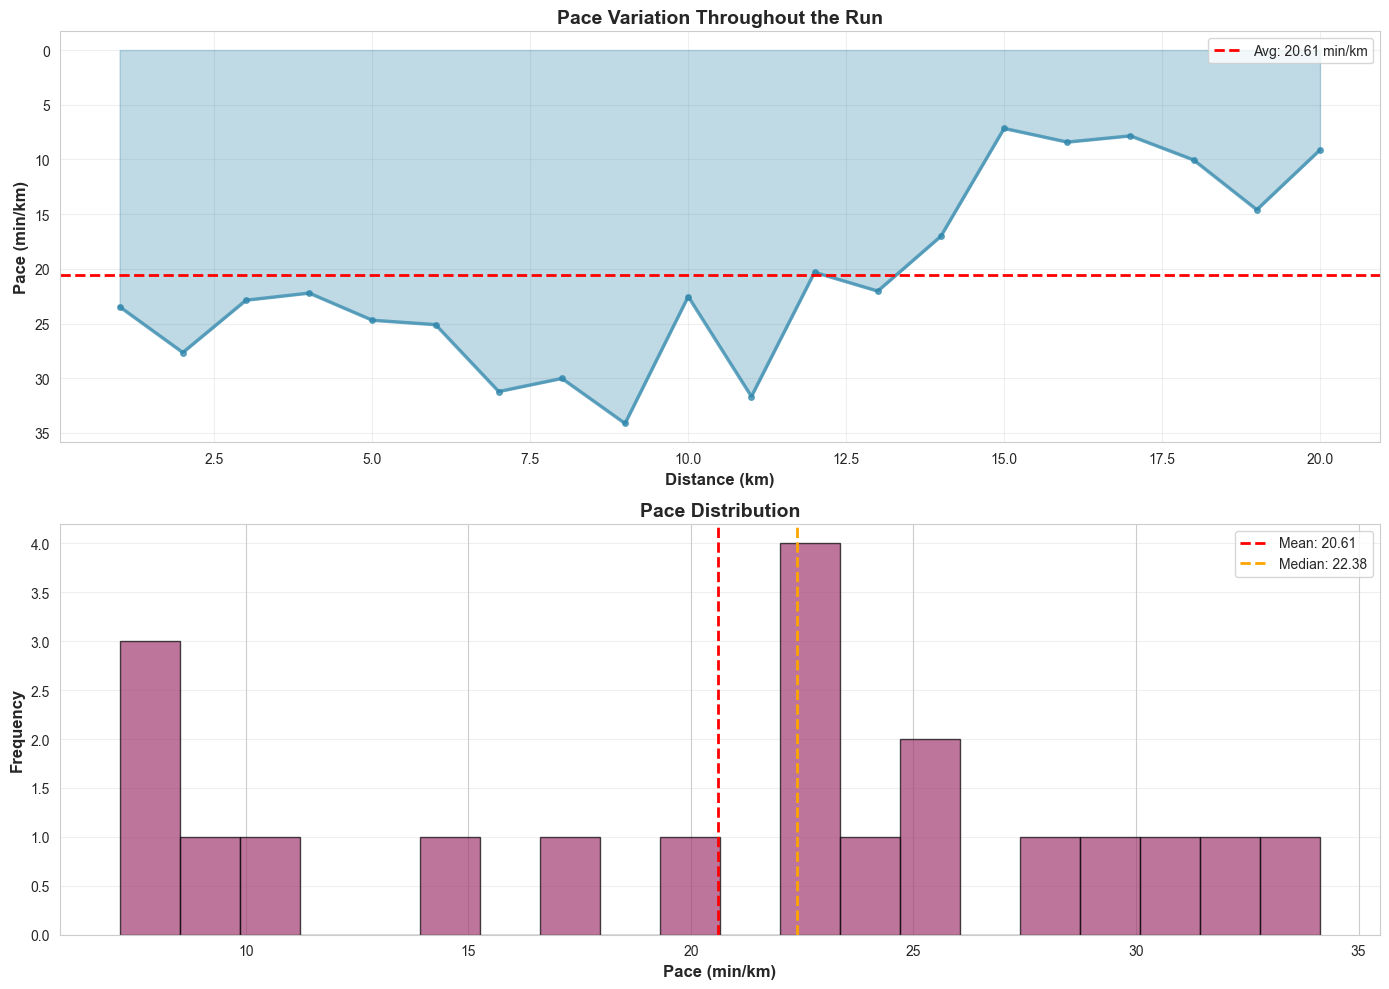


📊 PACE INSIGHTS:
Fastest km: 7.17 min/km (km 15)
Slowest km: 34.13 min/km (km 9)
Pace variation: 8.58 min/km std dev


In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Pace over distance
ax1.plot(splits_df['distance_km'], splits_df['pace_minutes'], 
         color='#2E86AB', linewidth=2.5, marker='o', markersize=4, alpha=0.7)
ax1.fill_between(splits_df['distance_km'], splits_df['pace_minutes'], 
                  alpha=0.3, color='#2E86AB')
ax1.axhline(y=splits_df['pace_minutes'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Avg: {splits_df["pace_minutes"].mean():.2f} min/km')
ax1.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold')
ax1.set_title('Pace Variation Throughout the Run', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()  # Faster pace at top

# Pace distribution
ax2.hist(splits_df['pace_minutes'], bins=20, color='#A23B72', alpha=0.7, edgecolor='black')
ax2.axvline(x=splits_df['pace_minutes'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {splits_df["pace_minutes"].mean():.2f}')
ax2.axvline(x=splits_df['pace_minutes'].median(), color='orange', 
            linestyle='--', linewidth=2, label=f'Median: {splits_df["pace_minutes"].median():.2f}')
ax2.set_xlabel('Pace (min/km)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Pace Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Key insights
print("\n📊 PACE INSIGHTS:")
print(f"Fastest km: {splits_df['pace_minutes'].min():.2f} min/km (km {splits_df.loc[splits_df['pace_minutes'].idxmin(), 'Lap']})")
print(f"Slowest km: {splits_df['pace_minutes'].max():.2f} min/km (km {splits_df.loc[splits_df['pace_minutes'].idxmax(), 'Lap']})")
print(f"Pace variation: {splits_df['pace_minutes'].std():.2f} min/km std dev")

## 2. Heart Rate Analysis

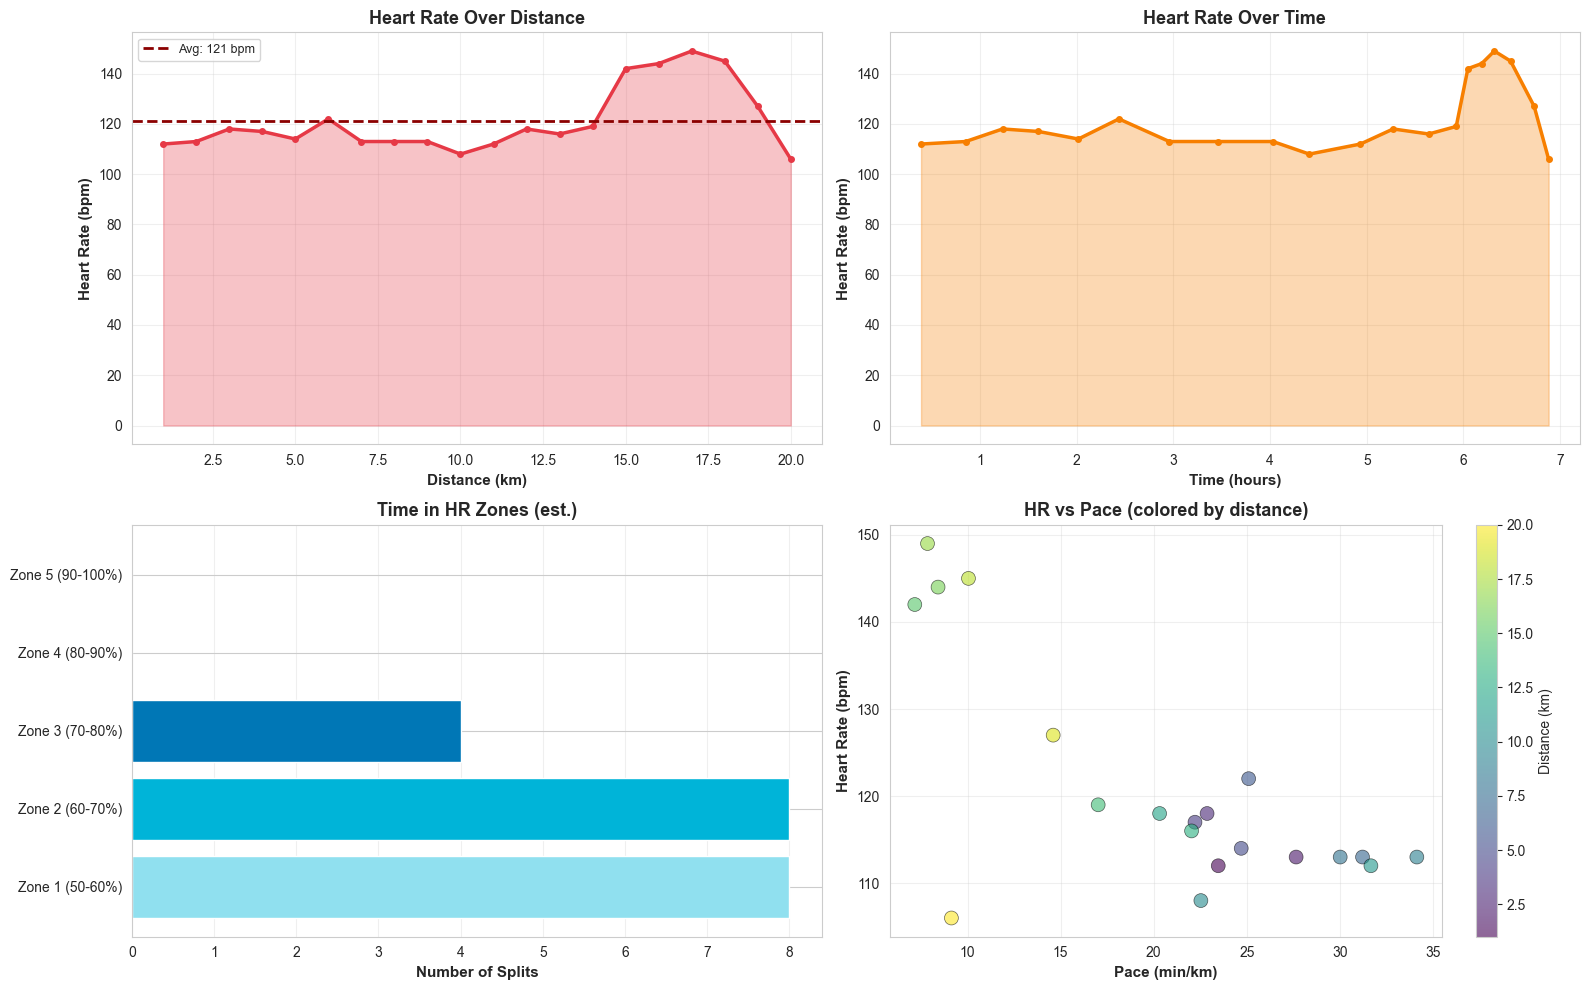

Average HR: 121 bpm
Min HR: 106 bpm (km 20)
Max HR: 149 bpm (km 17)
HR Standard Deviation: 13.2 bpm


In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# HR over distance
ax1.plot(splits_df['distance_km'], splits_df['Avg HR'], 
         color='#E63946', linewidth=2.5, marker='o', markersize=4)
ax1.fill_between(splits_df['distance_km'], splits_df['Avg HR'], 
                  alpha=0.3, color='#E63946')
ax1.axhline(y=splits_df['Avg HR'].mean(), color='darkred', 
            linestyle='--', linewidth=2, label=f'Avg: {splits_df["Avg HR"].mean():.0f} bpm')
ax1.set_xlabel('Distance (km)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Heart Rate (bpm)', fontsize=11, fontweight='bold')
ax1.set_title('Heart Rate Over Distance', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# HR over time
ax2.plot(splits_df['cumulative_time_hours'], splits_df['Avg HR'], 
         color='#F77F00', linewidth=2.5, marker='o', markersize=4)
ax2.fill_between(splits_df['cumulative_time_hours'], splits_df['Avg HR'], 
                  alpha=0.3, color='#F77F00')
ax2.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Heart Rate (bpm)', fontsize=11, fontweight='bold')
ax2.set_title('Heart Rate Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# HR distribution and zones
hr_zones = {
    'Zone 1 (50-60%)': (0.50, 0.60, '#90E0EF'),
    'Zone 2 (60-70%)': (0.60, 0.70, '#00B4D8'),
    'Zone 3 (70-80%)': (0.70, 0.80, '#0077B6'),
    'Zone 4 (80-90%)': (0.80, 0.90, '#FF6B6B'),
    'Zone 5 (90-100%)': (0.90, 1.00, '#C1121F')
}

max_hr_estimate = 220 - 30  # Assuming age ~30, adjust as needed
hr_percentages = splits_df['Avg HR'] / max_hr_estimate

zone_counts = {}
for zone_name, (low, high, color) in hr_zones.items():
    count = ((hr_percentages >= low) & (hr_percentages < high)).sum()
    zone_counts[zone_name] = count

ax3.barh(list(zone_counts.keys()), list(zone_counts.values()), 
         color=['#90E0EF', '#00B4D8', '#0077B6', '#FF6B6B', '#C1121F'])
ax3.set_xlabel('Number of Splits', fontsize=11, fontweight='bold')
ax3.set_title('Time in HR Zones (est.)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# HR vs Pace scatter
scatter = ax4.scatter(splits_df['pace_minutes'], splits_df['Avg HR'], 
                     c=splits_df['distance_km'], cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Pace (min/km)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Heart Rate (bpm)', fontsize=11, fontweight='bold')
ax4.set_title('HR vs Pace (colored by distance)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Distance (km)', fontsize=10)

plt.tight_layout()
plt.show()

# HR insights
print(f"Average HR: {splits_df['Avg HR'].mean():.0f} bpm")
print(f"Min HR: {splits_df['Avg HR'].min():.0f} bpm (km {splits_df.loc[splits_df['Avg HR'].idxmin(), 'Lap']})")
print(f"Max HR: {splits_df['Avg HR'].max():.0f} bpm (km {splits_df.loc[splits_df['Avg HR'].idxmax(), 'Lap']})")
print(f"HR Standard Deviation: {splits_df['Avg HR'].std():.1f} bpm")

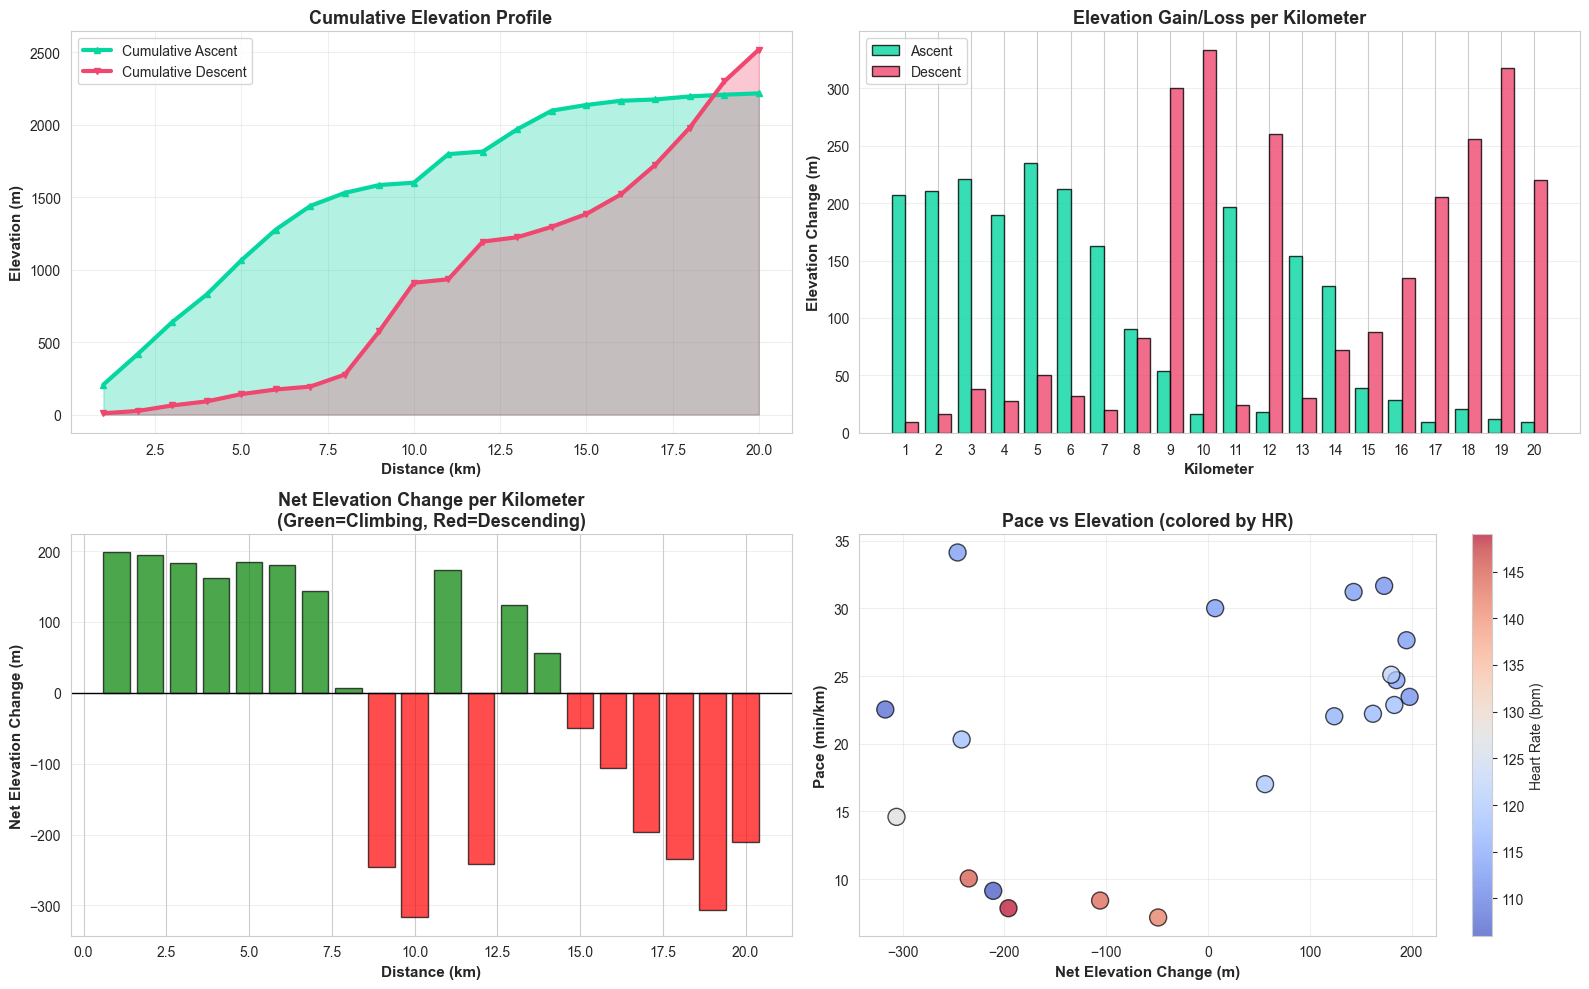


 ELEVATION INSIGHTS:
Total Ascent: 2215m
Total Descent: 2517m
Net Elevation Change: -302m
Biggest climb: 235.0m (km 5)
Biggest descent: 333.0m (km 10)


In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Cumulative elevation profile
cumulative_ascent = splits_df['ascent_m'].cumsum()
cumulative_descent = splits_df['descent_m'].cumsum()

ax1.plot(splits_df['distance_km'], cumulative_ascent, 
         color='#06D6A0', linewidth=3, marker='^', markersize=5, label='Cumulative Ascent')
ax1.plot(splits_df['distance_km'], cumulative_descent, 
         color='#EF476F', linewidth=3, marker='v', markersize=5, label='Cumulative Descent')
ax1.fill_between(splits_df['distance_km'], cumulative_ascent, alpha=0.3, color='#06D6A0')
ax1.fill_between(splits_df['distance_km'], cumulative_descent, alpha=0.3, color='#EF476F')
ax1.set_xlabel('Distance (km)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Elevation (m)', fontsize=11, fontweight='bold')
ax1.set_title('Cumulative Elevation Profile', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Ascent/Descent per km
x = np.arange(len(splits_df))
width = 0.4
ax2.bar(x - width/2, splits_df['ascent_m'], width, label='Ascent', 
        color='#06D6A0', alpha=0.8, edgecolor='black')
ax2.bar(x + width/2, splits_df['descent_m'], width, label='Descent', 
        color='#EF476F', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Kilometer', fontsize=11, fontweight='bold')
ax2.set_ylabel('Elevation Change (m)', fontsize=11, fontweight='bold')
ax2.set_title('Elevation Gain/Loss per Kilometer', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(splits_df['Lap'])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Net elevation change per km
net_elevation = splits_df['ascent_m'] - splits_df['descent_m']
colors = ['green' if x > 0 else 'red' for x in net_elevation]
ax3.bar(splits_df['distance_km'], net_elevation, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Distance (km)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Net Elevation Change (m)', fontsize=11, fontweight='bold')
ax3.set_title('Net Elevation Change per Kilometer\n(Green=Climbing, Red=Descending)', 
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Pace vs Elevation correlation
ax4.scatter(net_elevation, splits_df['pace_minutes'], 
           c=splits_df['Avg HR'], cmap='coolwarm', s=150, 
           alpha=0.7, edgecolors='black', linewidth=1)
ax4.set_xlabel('Net Elevation Change (m)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Pace (min/km)', fontsize=11, fontweight='bold')
ax4.set_title('Pace vs Elevation (colored by HR)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Heart Rate (bpm)', fontsize=10)

plt.tight_layout()
plt.show()

# Elevation insights
print("\n ELEVATION INSIGHTS:")
print(f"Total Ascent: {splits_df['ascent_m'].sum():.0f}m")
print(f"Total Descent: {splits_df['descent_m'].sum():.0f}m")
print(f"Net Elevation Change: {splits_df['ascent_m'].sum() - splits_df['descent_m'].sum():.0f}m")
print(f"Biggest climb: {splits_df['ascent_m'].max():.1f}m (km {splits_df.loc[splits_df['ascent_m'].idxmax(), 'Lap']})")
print(f"Biggest descent: {splits_df['descent_m'].max():.1f}m (km {splits_df.loc[splits_df['descent_m'].idxmax(), 'Lap']})")

As you can see, heres a small snippet of code to export the processed data to a CSV file, and with the csv we can do further analysis as the ones mentioned above. This gpx to csv script will help out later on to train our prediction models with varios gpx files converted to csv.